In [1]:
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
import lib

In [3]:
shear_step_plus = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"
shear_step_minus = "g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

In [4]:
NBINS = 100
bins = [
    np.linspace(0, 3, NBINS + 1),
    np.linspace(-1.5, 1.5, NBINS + 1),
] 

In [5]:
NBINS = 100
bins = np.linspace(0, 3, NBINS + 1)
centers = 0.5 * (bins[:-1] + bins[1:])

shear_step = shear_step_plus
with (
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step]) as shear,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step]) as truth,
    # h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step]) as tomo,
    # h5py.File(lib.const.SIM_WEIGHT_CATALOGS[shear_step]) as weight,
):
    flux_g = shear["mdet"]["noshear"]["pgauss_band_flux_g"][:]
    flux_i = shear["mdet"]["noshear"]["pgauss_band_flux_i"][:]
    color = lib.util.flux_to_mag(flux_g) - lib.util.flux_to_mag(flux_i)

    redshift = truth["mdet"]["noshear"]["z"][:]

    mean, _, _ = stats.binned_statistic(
        redshift,
        color - lib.const.GI_COLOR,
        statistic="mean",
        bins=bins,
    )

    std, _, _ = stats.binned_statistic(
        redshift,
        color - lib.const.GI_COLOR,
        statistic="std",
        bins=bins,
    )

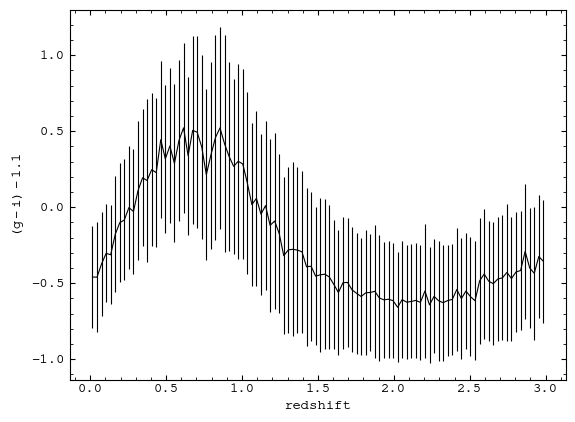

In [6]:
# plt.fill_between(centers, mean - std, mean + std, alpha=0.1, fc="k")
plt.errorbar(centers, mean, std, c="k")

plt.xlabel("redshift")
plt.ylabel(f"$(g - i) - {lib.const.GI_COLOR}$")

plt.show()
    

In [7]:
NBINS = 100
bins = np.linspace(0, 3, NBINS + 1)
centers = 0.5 * (bins[:-1] + bins[1:])

count = {}
mean = {}
std = {}

shear_step = shear_step_plus
with (
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step]) as shear,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step]) as truth,
    h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step]) as tomo,
    # h5py.File(lib.const.SIM_WEIGHT_CATALOGS[shear_step]) as weight,
):
    flux_g = shear["mdet"]["noshear"]["pgauss_band_flux_g"][:]
    flux_i = shear["mdet"]["noshear"]["pgauss_band_flux_i"][:]
    color = lib.util.flux_to_mag(flux_g) - lib.util.flux_to_mag(flux_i)

    redshift = truth["mdet"]["noshear"]["z"][:]

    bhat = tomo["sompz"]["noshear"]["bhat"][:]


    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
        in_tomo = (bhat == tomographic_bin)

        _count, _, _ = stats.binned_statistic(
            redshift[in_tomo],
            color[in_tomo] - lib.const.GI_COLOR,
            statistic="count",
            bins=bins,
        )
        count[tomographic_bin] = _count

        _mean, _, _ = stats.binned_statistic(
            redshift[in_tomo],
            color[in_tomo] - lib.const.GI_COLOR,
            statistic="mean",
            bins=bins,
        )
        mean[tomographic_bin] = _mean
    
        _std, _, _ = stats.binned_statistic(
            redshift[in_tomo],
            color[in_tomo] - lib.const.GI_COLOR,
            statistic="std",
            bins=bins,
        )
        std[tomographic_bin] = _std

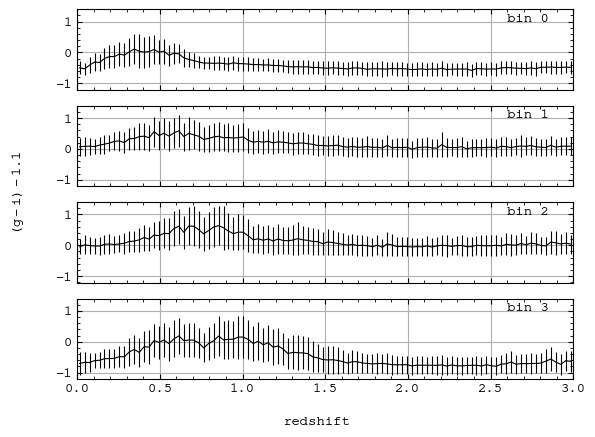

In [10]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    # axs[tomographic_bin].fill_between(
    #     centers,
    #     mean[tomographic_bin] - std[tomographic_bin],
    #     mean[tomographic_bin] + std[tomographic_bin],
    #     alpha=0.1,
    #     fc="k",
    # )
    axs[tomographic_bin].errorbar(
        centers,
        mean[tomographic_bin],
        std[tomographic_bin],
        c="k",
    )

    axs[tomographic_bin].text(
        0.95, 0.95,
        f"bin {tomographic_bin}",
        ha="right",
        va="top",
        transform=axs[tomographic_bin].transAxes,
    )

    axs[tomographic_bin].set_xlim(0, 3)
    axs[tomographic_bin].grid()

fig.supxlabel("redshift")
fig.supylabel(f"$(g - i) - {lib.const.GI_COLOR}$")

plt.show()
    

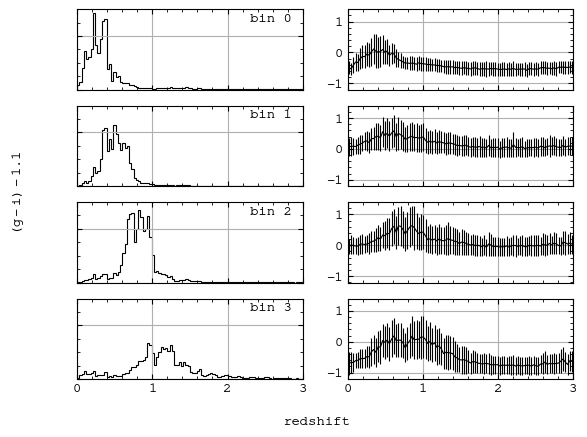

In [15]:
fig, axs = plt.subplots(4, 2, sharex=True, sharey="col")

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    # axs[tomographic_bin].fill_between(
    #     centers,
    #     mean[tomographic_bin] - std[tomographic_bin],
    #     mean[tomographic_bin] + std[tomographic_bin],
    #     alpha=0.1,
    #     fc="k",
    # )
    axs[tomographic_bin, 0].stairs(
        count[tomographic_bin],
        bins,
        ec="k",
    )

    axs[tomographic_bin, 0].text(
        0.95, 0.95,
        f"bin {tomographic_bin}",
        ha="right",
        va="top",
        transform=axs[tomographic_bin, 0].transAxes,
    )
    
    axs[tomographic_bin, 1].errorbar(
        centers,
        mean[tomographic_bin],
        std[tomographic_bin],
        c="k",
    )

    axs[tomographic_bin, 0].grid()
    axs[tomographic_bin, 1].grid()

    axs[tomographic_bin, 0].set_xlim(0, 3)
    axs[tomographic_bin, 1].set_xlim(0, 3)

    axs[tomographic_bin, 0].set_yticklabels([])


fig.supxlabel("redshift")
fig.supylabel(f"$(g - i) - {lib.const.GI_COLOR}$")

plt.show()
    

AttributeError: 'Axes' object has no attribute 'ravel'

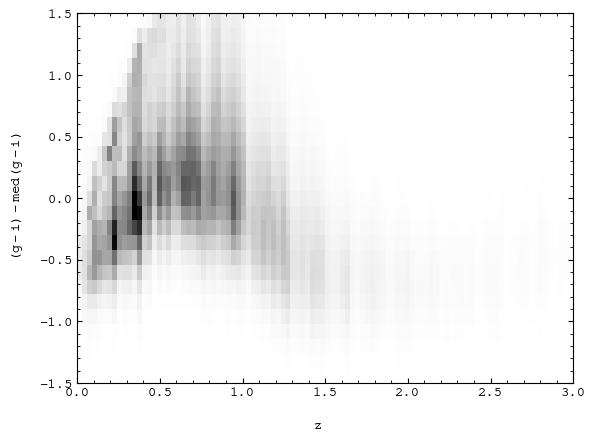

In [29]:
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)

norm = mpl.colors.Normalize(vmin=0)
cmap = "binary"

shear_step = shear_step_plus
with (
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step]) as shear,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step]) as truth,
    # h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step]) as tomo,
    # h5py.File(lib.const.SIM_WEIGHT_CATALOGS[shear_step]) as weight,
):
    flux_g = shear["mdet"]["noshear"]["pgauss_band_flux_g"][:]
    flux_i = shear["mdet"]["noshear"]["pgauss_band_flux_i"][:]
    color = lib.util.flux_to_mag(flux_g) - lib.util.flux_to_mag(flux_i)

    redshift = truth["mdet"]["noshear"]["z"][:]

    axs.hist2d(
        redshift,
        color - lib.const.GI_COLOR,
        bins=bins,
        norm=norm,
        cmap=cmap,
    )

        
fig.supxlabel("$z$")
fig.supylabel("$(g - i) - med(g - i)$")


plt.show()           

In [ ]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)

norm = mpl.colors.Normalize(vmin=0)
cmap = "binary"

shear_step = shear_step_plus
with (
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step]) as shear,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step]) as truth,
    h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step]) as tomo,
    # h5py.File(lib.const.SIM_WEIGHT_CATALOGS[shear_step]) as weight,
):
    flux_g = shear["mdet"]["noshear"]["pgauss_band_flux_g"][:]
    flux_i = shear["mdet"]["noshear"]["pgauss_band_flux_i"][:]
    color = lib.util.flux_to_mag(flux_g) - lib.util.flux_to_mag(flux_i)

    redshift = truth["mdet"]["noshear"]["z"][:]

    bhat = tomo["sompz"]["noshear"]["bhat"][:]


    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
        in_tomo = (bhat == tomographic_bin)

        axs[tomographic_bin].hist2d(
            redshift[in_tomo],
            color[in_tomo] - lib.const.GI_COLOR,
            bins=bins,
            norm=norm,
            cmap=cmap,
        )

        axs[tomographic_bin].text(
            0.95, 0.95,
            f"bin {tomographic_bin}",
            ha="right",
            va="top",
            transform=axs[tomographic_bin].transAxes,
        )
        
fig.supxlabel("$z$")
fig.supylabel("$(g - i) - med(g - i)$")

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs.ravel(),
)

plt.show()           